In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.4.0


In [2]:
from saved_func_show_heatmaps import show_heatmaps

## Masked softmax operation

In [3]:
def sequence_mask(X, valid_len, value = 0):
    """Mask irrelevant entries in sequences.
    Input argument X of this function is 2D.
    """
    maxlen = X.shape[1]
    mask = tf.range(start = 0, limit = maxlen, dtype = tf.float32)[None, :] < tf.cast(valid_len[:, None], dtype = tf.float32)
    return tf.where(mask, X, value)

In [4]:
def masked_softmax(X, valid_lens):
    """X: 3D tensor
       valid_lens: 1D or 2D tensor
       When valid_lens is 1D, its `len(valid_lens)` should be same as `X.shape[0]`.
       When valid_lens is 2D, `valid_lens.shape` should be same as `X.shape[:2]`.
    """
    if valid_lens is None:
        return tf.nn.softmax(X, axis = -1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            if (len(valid_lens) == X.shape[0]): 
                valid_lens = tf.repeat(valid_lens, repeats = shape[1])
            else:
                print("Valid_lens shape is incompatible with input. Read docstring of `masked_softmax` function.")
        else:
            if (valid_lens.shape == X.shape[:2]):
                valid_lens = tf.reshape(valid_lens, shape = -1)
            else:
                print("Valid_lens shape is incompatible with input. Read docstring of `masked_softmax` function.")
            
        
        X = sequence_mask(tf.reshape(X, shape = (-1, shape[-1])), valid_lens, value=-1e6)    
        return tf.nn.softmax(tf.reshape(X, shape = shape), axis = -1)

In [5]:
masked_softmax(tf.random.uniform(shape = (2, 2, 4)), tf.constant([2, 3]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.47316122, 0.5268388 , 0.        , 0.        ],
        [0.50380087, 0.4961991 , 0.        , 0.        ]],

       [[0.2242239 , 0.2310319 , 0.54474425, 0.        ],
        [0.33668607, 0.3555478 , 0.3077661 , 0.        ]]], dtype=float32)>

In [6]:
masked_softmax(tf.random.uniform((3, 2, 4)), tf.constant([[1, 3], [2, 4], [1, 2]]))

<tf.Tensor: shape=(3, 2, 4), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        , 0.        ],
        [0.4714767 , 0.28774014, 0.24078313, 0.        ]],

       [[0.624564  , 0.37543604, 0.        , 0.        ],
        [0.26083523, 0.35128734, 0.21069005, 0.17718741]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.5287057 , 0.47129422, 0.        , 0.        ]]], dtype=float32)>

## Additive attention
$$f(q, (k_1, v_1), (k_2, v_2), ..., (k_m, v_m)) = \Sigma_{i = 1}^n{\alpha{(q, k_i)}v_i}$$
$\mathbf{q}\in \mathbb{R}^q$,$\mathbf{k}_i\in \mathbb{R}^k$, $\mathbf{v}_i\in \mathbb{R}^v$

$$\alpha(\mathbf{q}, \mathbf{k}_i) = softmax(a(\mathbf{q}, \mathbf{k}_i)) = \frac{exp(a(\mathbf{q}, \mathbf{k}_i))}
{\Sigma_{j=1}^nexp(a(\mathbf{q}, \mathbf{k}_j))}$$

Attention weights = $\alpha{(q, k_i)}$. In addtive attention,
$$a(\mathbf{q}, \mathbf{k}) = \mathbf{w}_v^Ttanh(\mathbf{W}_q\mathbf{q} + \mathbf{W}_k\mathbf{k}) \in \mathbb{R}$$

In [7]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias = False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias = False)
        self.w_v = tf.keras.layers.Dense(1, use_bias = False)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, queries, keys, values, valid_lens, training):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = tf.expand_dims(queries, axis = 2) + tf.expand_dims(keys, axis = 1)
        features = tf.nn.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = tf.squeeze(self.w_v(features), axis = -1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return tf.matmul(self.dropout(self.attention_weights, training = training), values)

In [8]:
queries, keys = tf.random.normal(shape = (2, 1, 20)), tf.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = tf.repeat(tf.reshape(tf.range(40, dtype=tf.float32), shape = (1, 10, 4)), repeats = 2, axis = 0)
valid_lens = tf.constant([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention(queries, keys, values, valid_lens, training = False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.,  3.,  4.,  5.]],

       [[10., 11., 12., 13.]]], dtype=float32)>

In [9]:
attention.attention_weights

<tf.Tensor: shape=(2, 1, 10), dtype=float32, numpy=
array([[[0.5       , 0.5       , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667, 0.        , 0.        , 0.        , 0.        ]]],
      dtype=float32)>

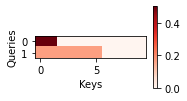

In [10]:
show_heatmaps(tf.expand_dims(tf.reshape(attention.attention_weights, shape = (1,2,10)), axis = 0),
              xlabel='Keys',
              ylabel='Queries')

## Scaled dot-product attention
$$a(\mathbf{q}, \mathbf{k}) = \mathbf{q}^T\mathbf{k}/\sqrt{d}$$
For $n$ queries and $m$ key-value pairs (each of dimension $d$), 
$$softmax(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d}})\mathbf{V} \in \mathbb{R}^{n\times v}$$

In [11]:
class DotProductAttention(tf.keras.layers.Layer):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def call(self, queries, keys, values, valid_lens, training):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b = True)/tf.math.sqrt(tf.cast(d, dtype = tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, training = training), values)

In [12]:
queries = tf.random.normal(shape = (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training = False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.,  3.,  4.,  5.]],

       [[10., 11., 12., 13.]]], dtype=float32)>

In [13]:
attention.attention_weights

<tf.Tensor: shape=(2, 1, 10), dtype=float32, numpy=
array([[[0.5       , 0.5       , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667, 0.        , 0.        , 0.        , 0.        ]]],
      dtype=float32)>

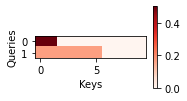

In [14]:
show_heatmaps(tf.expand_dims(tf.reshape(attention.attention_weights, shape = (1,2,10)), axis = 0),
              xlabel='Keys',
              ylabel='Queries')